<div style="font-family: system-ui, -apple-system, BlinkMacSystemFont, 'Segoe UI', sans-serif; border: 1px solid #ddd; border-radius: 10px; padding: 16px 20px; margin-bottom: 16px; background: #fafafa;">
  <h1 style="margin-top: 0; margin-bottom: 8px; font-size: 24px;">HAVI – 04_exploratory_analysis</h1>
  <p style="margin: 0 0 12px 0; font-size: 14px;">
    Cel: eksploracyjna analiza zbioru <code>master_model_ready</code> – struktura danych, rozkład wolumenów,
    trendy czasowe, sezonowość, zera popytu oraz korelacje cech numerycznych.
  </p>
</div>


### Cel analizy EDA

Celem tego etapu jest zrozumienie historycznego zachowania popytu
na poziomie pojedynczej serii produktowej w kraju.
Analiza ma charakter opisowy i diagnostyczny.


### Wczytanie danych do analizy

Wczytujemy przygotowane dane na poziomie serii
oraz metryki jakości obliczone w poprzednich etapach.


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from pathlib import Path

pd.set_option("display.max_columns", None)

BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "data"
PREP_DIR = DATA_DIR / "prepared"
FEAT_DIR = DATA_DIR / "features"

LEVELA_PATH = PREP_DIR / "series_level_a.parquet"
REG_PATH = PREP_DIR / "series_registry.csv"

df = pd.read_parquet(LEVELA_PATH)
reg = pd.read_csv(REG_PATH)

df["week_start"] = pd.to_datetime(df["week_start"])


### Zakres danych

Zbiór obejmuje tygodniowe obserwacje popytu dla sześciu rynków europejskich
w horyzoncie kilkuletnim, zróżnicowanym między krajami.


In [37]:
pd.Series({
    "Liczba obserwacji": len(df),
    "Liczba krajów": df["country"].nunique(),
    "Liczba SKU": df["sku"].nunique(),
    "Liczba DC": df["n_dc"].nunique(),

})

Liczba obserwacji    5810
Liczba krajów           6
Liczba SKU             22
Liczba DC               8
dtype: int64

In [38]:
sku_country = (
    df.groupby(["country", "sku", "product_name"], as_index=False)["demand"]
      .sum()
      .rename(columns={"demand": "total_demand"})
)

sku_country = sku_country[sku_country["total_demand"] > 0]
sku_country.head(22)

,country,sku,product_name,total_demand
0,Germany,00004-807-019,Pommes Frites I,1298257.000
1,Germany,00019-003-003,Coca Cola 20 L BIB,1822324.000
2,Poland,02589-489-000,TLUSZCZ,2706618.500
3,Poland,05243-022-000,KAWA,560149.500
4,Poland,16333-000-000,Herbata Mietowa,17682.700
5,Poland,62170-027-000,Chipsy PAPRYKA,11755.600
6,Portugal,00012-438-000,*LEITE SUNDAE,642189.500
7,Portugal,00012-619-000,LEITE SUNDAE,1690936.817
8,Portugal,00041-097-000,CHOC QT 05 MC,9592.344
9,Romania,00012-432-000,SUNDAE,297001.350


In [39]:
dc_countries = (
    df.loc[df["demand"].fillna(0) != 0, ["n_dc", "country"]] 
      .drop_duplicates()
      .groupby("n_dc", observed=False)["country"]
      .agg(
          n_countries="nunique",
          countries=lambda s: ", ".join(sorted(s.astype(str).unique()))
      )
      .reset_index()
      .sort_values(["n_countries", "n_dc"], ascending=[False, True])
)

dc_countries

,n_dc,n_countries,countries
1,2,6,"Germany, Poland, Portugal, Romania, Spain, Sweden"
0,1,5,"Germany, Poland, Portugal, Romania, Sweden"
2,3,5,"Germany, Poland, Portugal, Spain, Sweden"
3,4,3,"Poland, Spain, Sweden"
4,5,2,"Germany, Spain"
6,7,2,"Germany, Spain"
5,6,1,Spain
7,8,1,Germany


In [40]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 300)

dc_product_summary = (
    df.groupby(["n_dc", "product_name"], observed=False)["demand"]
      .sum()
      .reset_index()
)

dc_product_summary = dc_product_summary[dc_product_summary["demand"] > 0]

dc_product_overview = (
    dc_product_summary
    .sort_values(["n_dc", "demand"], ascending=[True, False])
    .groupby("n_dc", observed=False)
    .agg(
        n_products=("product_name", "nunique"),
        top_products=("product_name", lambda x: ", ".join(x.unique()))  
    )
    .reset_index()
    .sort_values("n_products", ascending=False)
)

dc_product_overview

,n_dc,n_products,top_products
1,2,14,"LEITE SUNDAE, *LEITE SUNDAE, SUNDAE, Pommes Frites I, PLACINTA VISINE, Cup Carrier, CLAM, Coffee, CHOC QT 05 MC, KAWA, Cinnamon, Chipsy PAPRYKA, CONO, Herbata Mietowa"
2,3,12,"SHAKE LOWFAT, Milk, TLUSZCZ, LEITE SUNDAE, KAWA, Chipsy PAPRYKA, Pommes Frites I, Herbata Mietowa, CHOC QT 05 MC, *GAZPACHO, CERVEZA 30L, Coca Cola 20 L BIB"
0,1,10,"Pommes Frites I, LEITE SUNDAE, Cinnamon, Tea, KAWA, CLAM, Coffee, CHOC QT 05 MC, Cup Carrier, Herbata Mietowa"
3,4,7,"TLUSZCZ, KAWA, Herbata Mietowa, SHAKE LOWFAT, Milk, GAZPACHO (17783-000), *GAZPACHO"
5,6,4,"CERVEZA 30L, GAZPACHO (17783-000), *GAZPACHO, CONO"
6,7,4,"CERVEZA 30L, GAZPACHO (17783-000), Coca Cola 20 L BIB, CONO"
4,5,3,"Coca Cola 20 L BIB, CONO, *GAZPACHO"
7,8,1,Coca Cola 20 L BIB


In [45]:
def prepare_top_products_for_year(df: pd.DataFrame, year: int, top_n: int = 5) -> pd.DataFrame:
    if "year" not in df.columns:
        df = df.copy()
        df["year"] = df["week_start"].dt.year

    agg = (
        df.groupby(["country", "year", "product_name"], observed=False)["demand"]
          .sum()
          .reset_index()
          .rename(columns={"demand": "total_demand"})
    )

    agg = agg[(agg["total_demand"] > 0) & (agg["year"] == year)].copy()

    if agg.empty:
        return agg

    top = (
        agg.sort_values(["country", "total_demand"], ascending=[True, False])
           .groupby("country", observed=False, as_index=False)
           .head(top_n)
           .copy()
    )

    country_order = (
        top.groupby("country", observed=False)["total_demand"]
           .sum()
           .sort_values(ascending=False)
           .index
           .tolist()
    )
    top["country"] = pd.Categorical(top["country"], categories=country_order, ordered=True)

    top = top.sort_values(["country", "total_demand"], ascending=[True, False]).reset_index(drop=True)

    return top

In [46]:
def plot_top_products_year(
    top_df: pd.DataFrame,
    year: int,
    title_prefix: str = "Top produkty – wolumen popytu",
    bar_width: float = 0.55,
):
    if top_df.empty:
        print(f"Brak danych dla roku {year}.")
        return

    x = np.arange(len(top_df))
    y = top_df["total_demand"].values
    labels = top_df["product_name"].astype(str).values

    fig, ax = plt.subplots(figsize=(16, 6))

    ax.bar(x, y, width=bar_width)

    ax.yaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{v:,.0f}"))

    ax.grid(axis="y", alpha=0.25)
    ax.set_axisbelow(True)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=35, ha="right")

    ax.set_ylabel("Wolumen / popyt (suma w roku)")
    ax.set_title(f"{title_prefix} ({year})", fontsize=14, fontweight="bold")

    countries = top_df["country"].astype(str).values
    boundaries = []
    start = 0
    for i in range(1, len(countries) + 1):
        if i == len(countries) or countries[i] != countries[i-1]:
            end = i - 1
            boundaries.append((countries[i-1], start, end))
            start = i

    for j, (c, s, e) in enumerate(boundaries):
        if j % 2 == 0:
            ax.axvspan(s - 0.5, e + 0.5, alpha=0.06)  

        mid = (s + e) / 2
        ax.text(
            mid, -0.22, c,
            ha="center", va="top",
            transform=ax.get_xaxis_transform(),  
            fontsize=11, fontweight="bold"
        )

        ax.axvline(e + 0.5, linewidth=0.8, alpha=0.25)

    plt.subplots_adjust(bottom=0.28)
    plt.tight_layout()
    plt.show()


In [47]:
df.columns.tolist()

['country',
 'sku',
 'week_start',
 'demand',
 'product_name',
 'n_dc',
 'is_outlier']

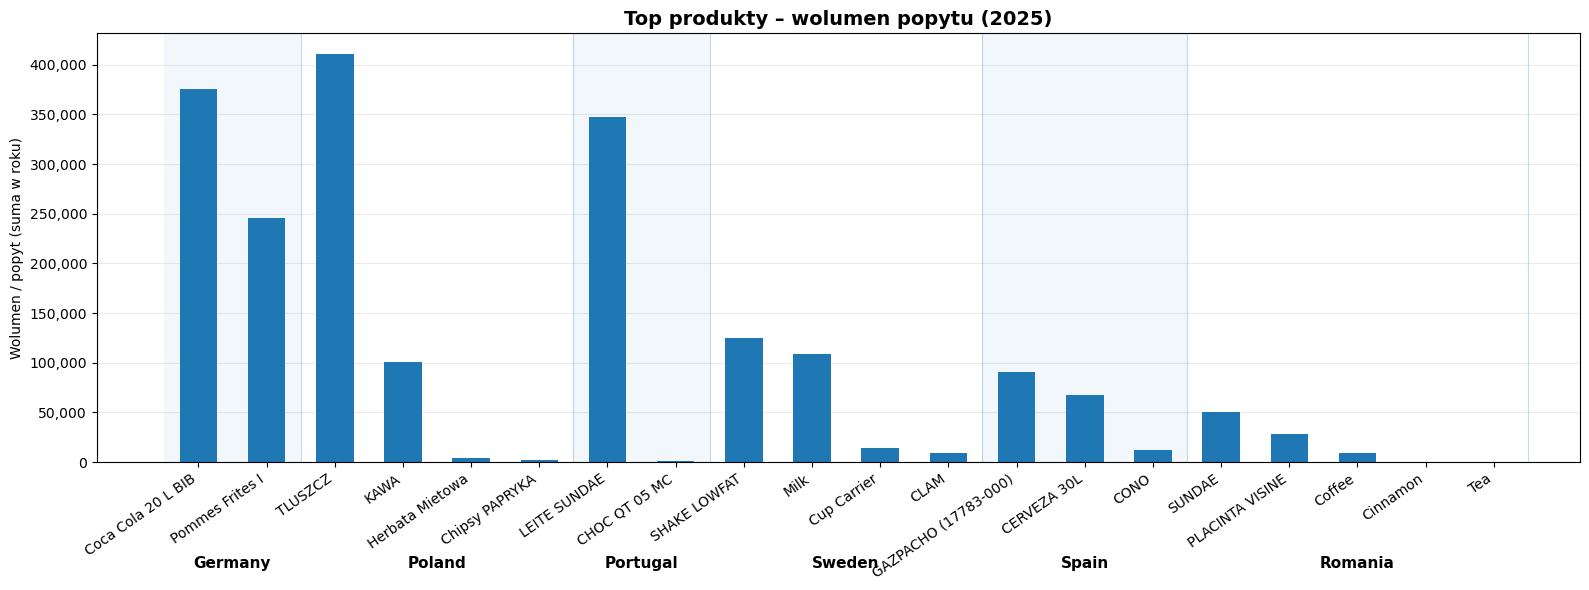

In [48]:
YEAR = 2025
top_year = prepare_top_products_for_year(df, year=YEAR, top_n=5)
plot_top_products_year(top_year, year=YEAR)


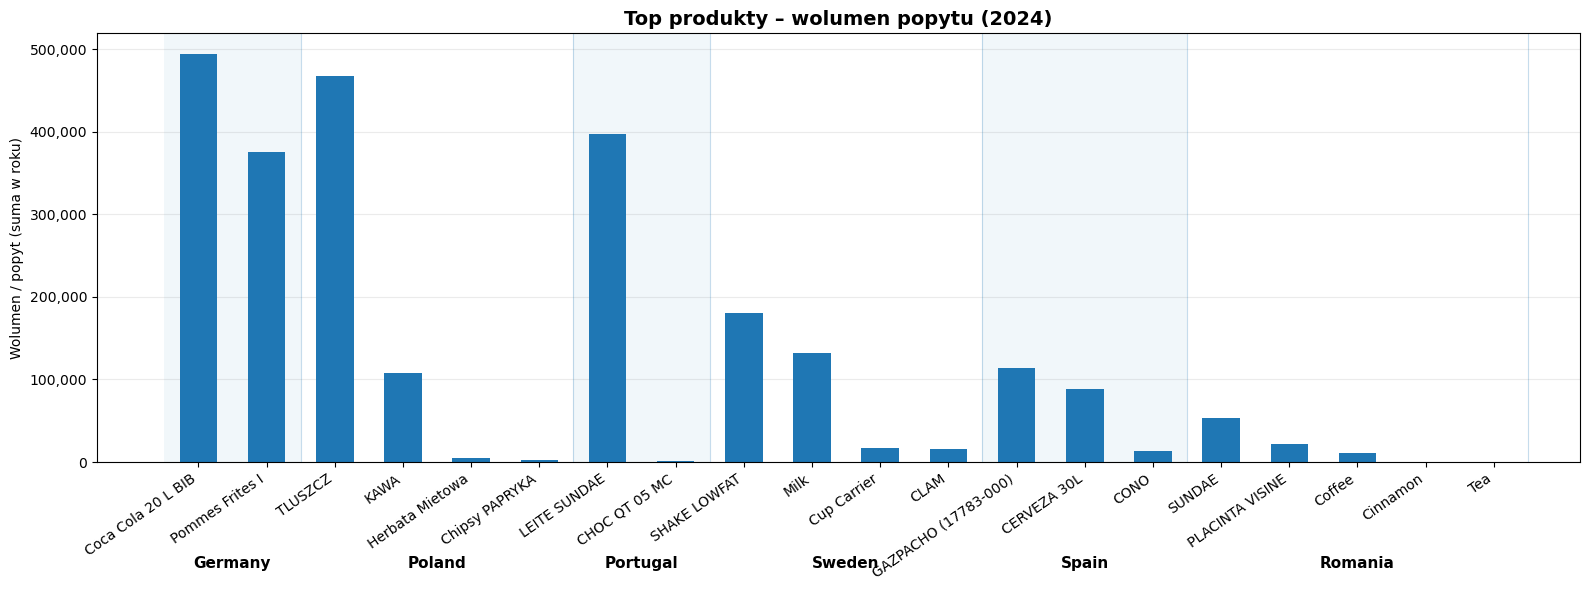

In [49]:
YEAR = 2024
top_year = prepare_top_products_for_year(df, year=YEAR, top_n=5)
plot_top_products_year(top_year, year=YEAR)


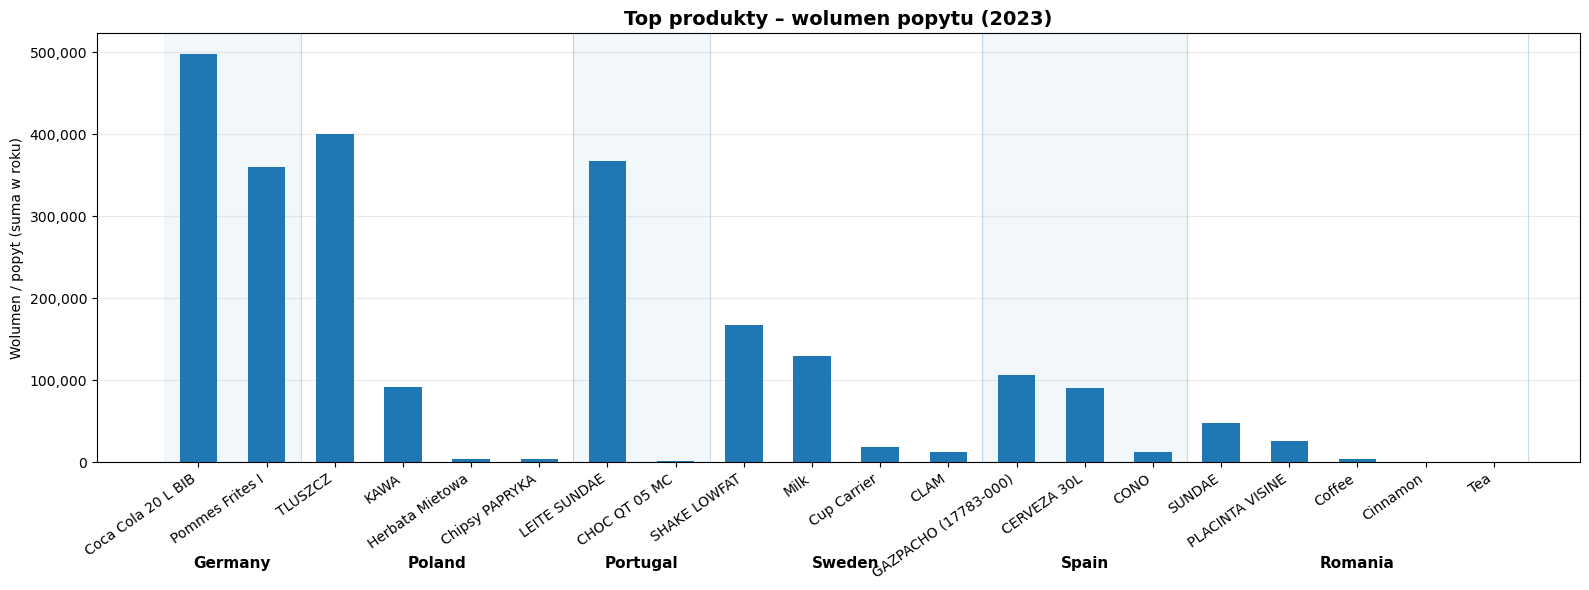

In [50]:
YEAR = 2023
top_year = prepare_top_products_for_year(df, year=YEAR, top_n=5)
plot_top_products_year(top_year, year=YEAR)

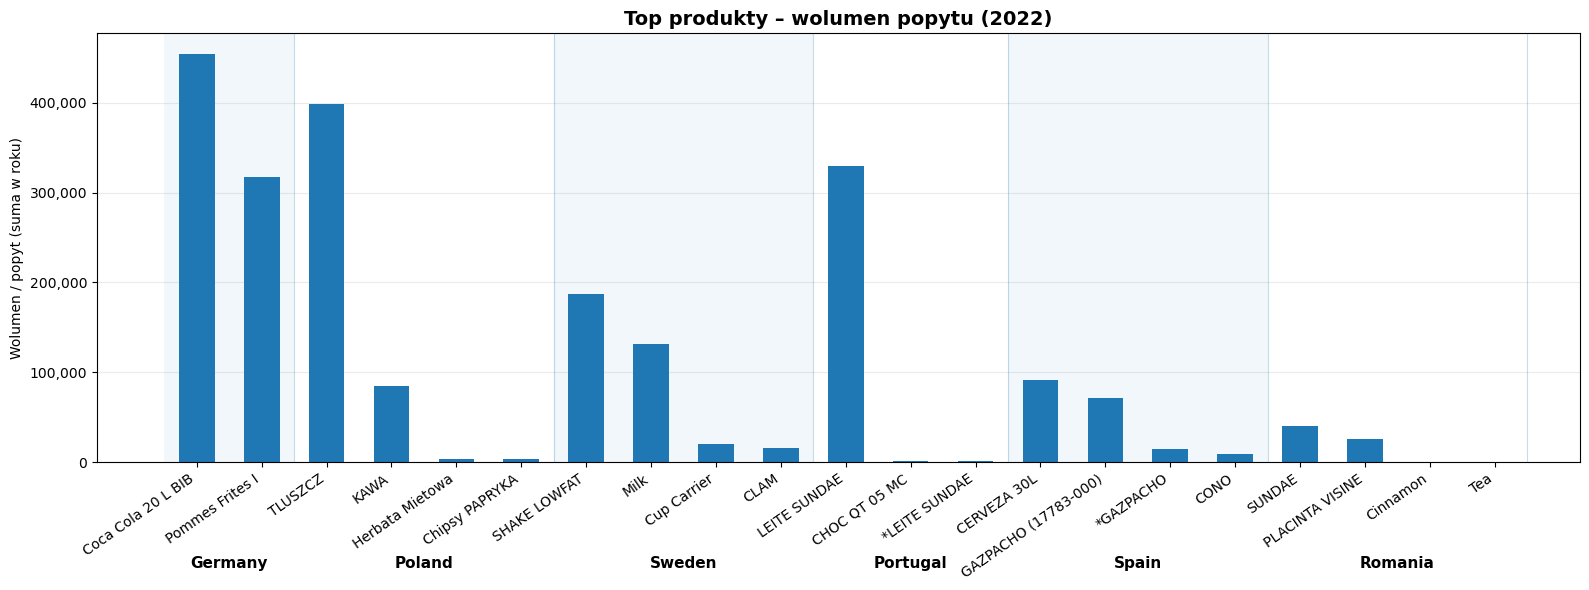

In [51]:
YEAR = 2022
top_year = prepare_top_products_for_year(df, year=YEAR, top_n=5)
plot_top_products_year(top_year, year=YEAR)

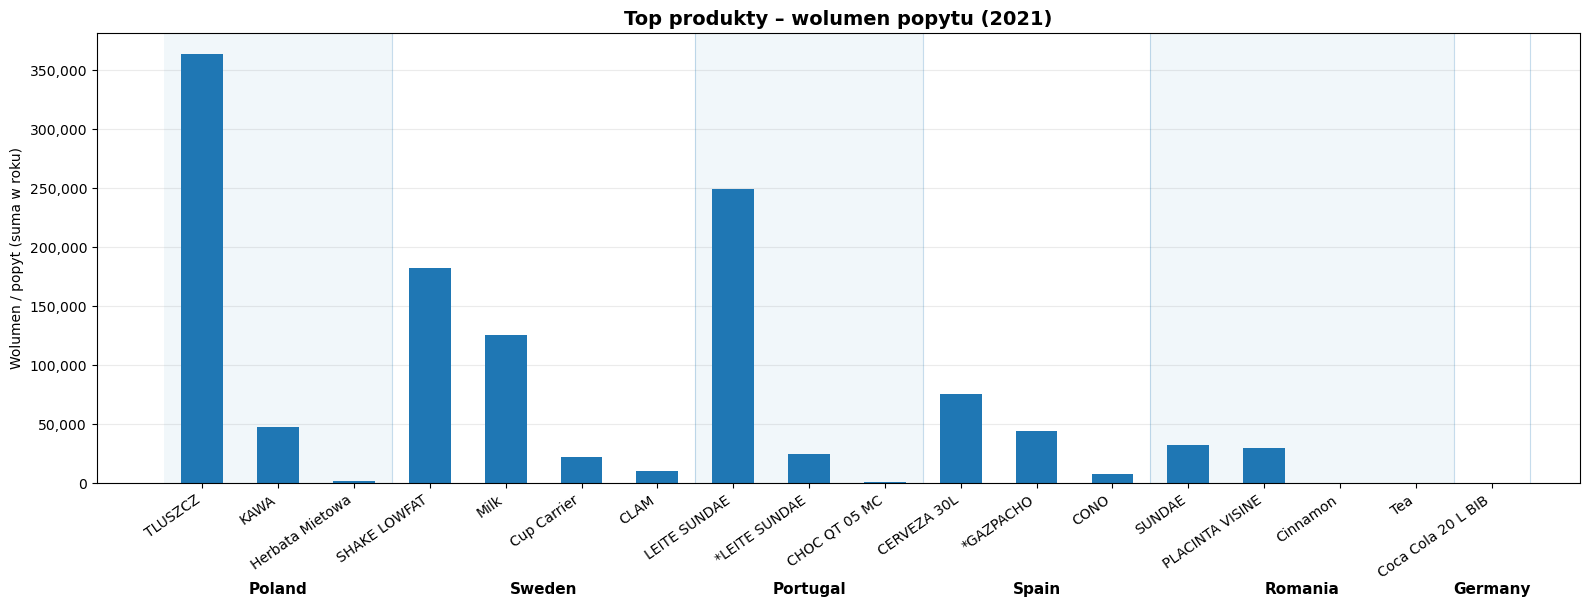

In [52]:
YEAR = 2021
top_year = prepare_top_products_for_year(df, year=YEAR, top_n=5)
plot_top_products_year(top_year, year=YEAR)


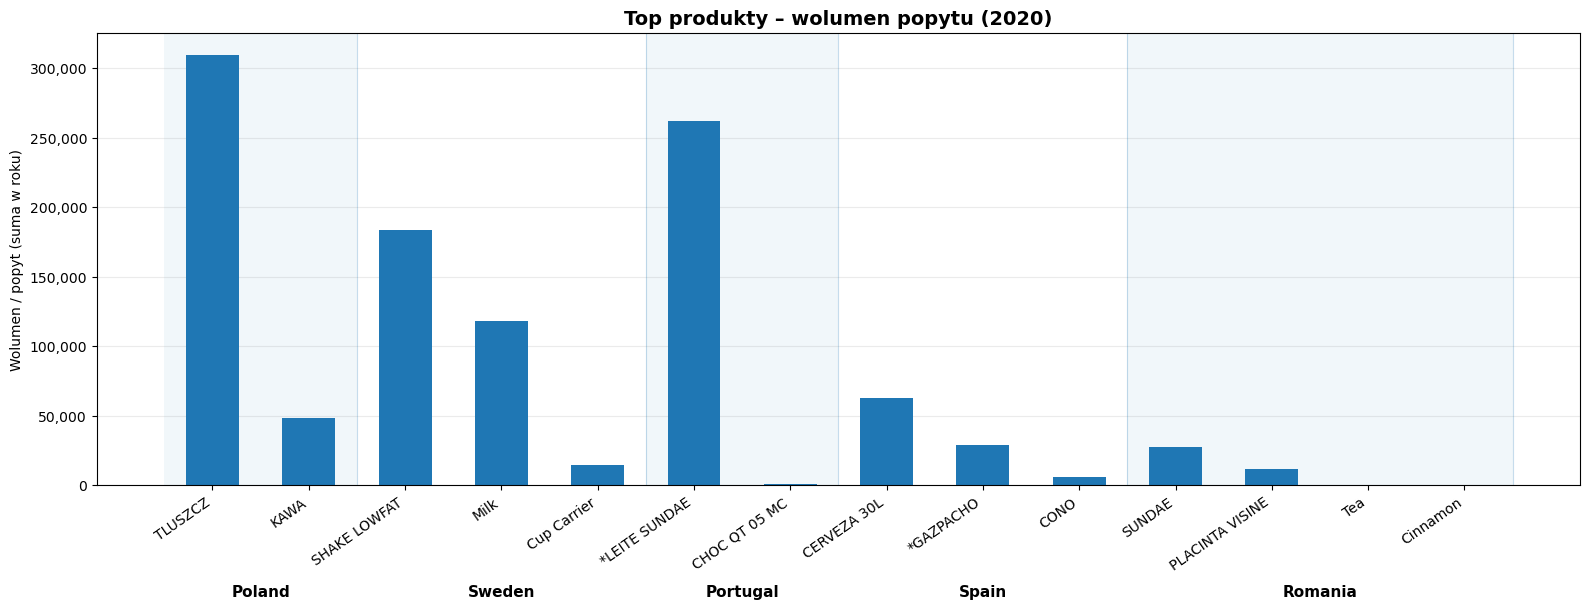

In [53]:
YEAR = 2020
top_year = prepare_top_products_for_year(df, year=YEAR, top_n=5)
plot_top_products_year(top_year, year=YEAR)


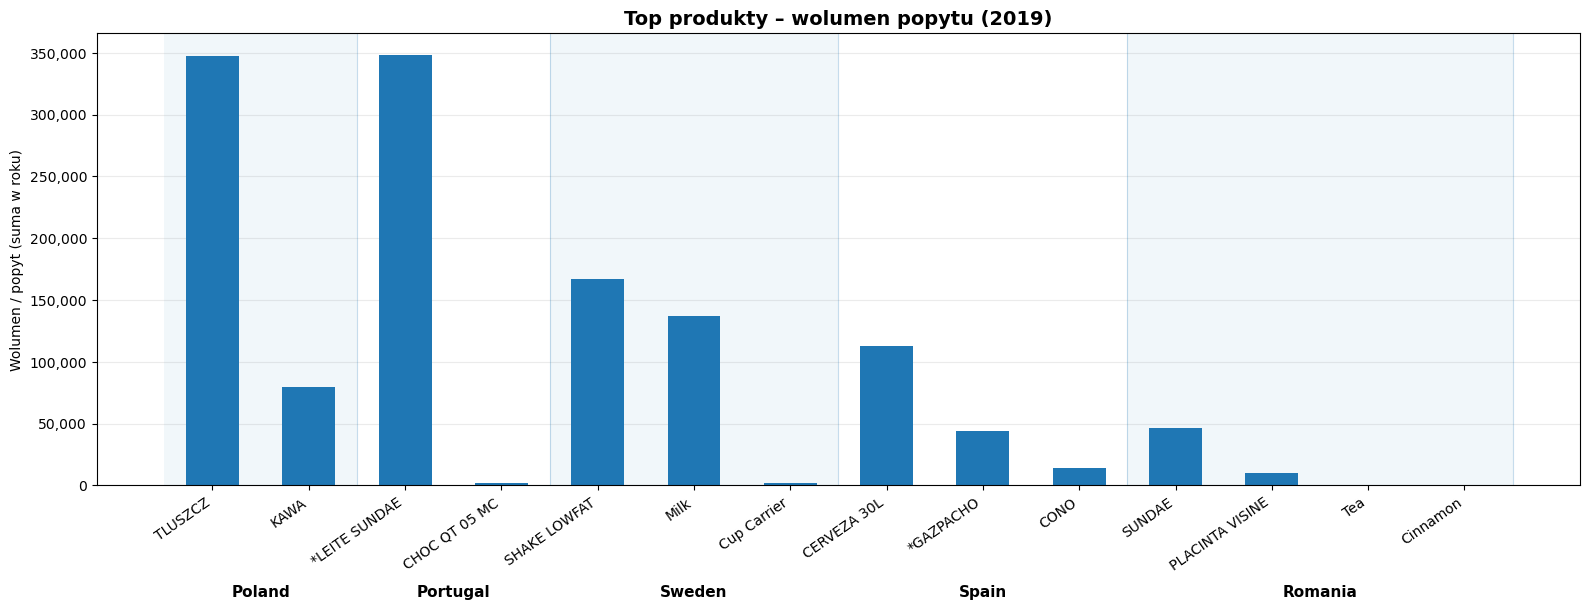

In [54]:
YEAR = 2019
top_year = prepare_top_products_for_year(df, year=YEAR, top_n=5)
plot_top_products_year(top_year, year=YEAR)


### Metryki jakości i wybór serii

Dołączamy metryki opisujące jakość i charakter popytu.
Analiza dotyczy pojedynczej serii wybranej przez użytkownika.


In [55]:
df = df.merge(
    reg,
    on=["country", "sku"],
    how="left"
)

df[["country", "product_name"]].drop_duplicates().head()


,country,product_name
0,Germany,Pommes Frites I
188,Germany,Coca Cola 20 L BIB
390,Poland,TLUSZCZ
747,Poland,KAWA
1085,Poland,Herbata Mietowa


In [56]:
COUNTRY = "Germany"
SKU = "00019-003-003"

s = (
    df[(df["country"] == COUNTRY) & (df["sku"] == SKU)]
    .sort_values("week_start")
    .copy()
)

s.head(), s.shape


(     country            sku week_start  demand        product_name  n_dc  is_outlier  longest_gap_weeks  missing_weeks  n_segments  n_weeks_obs  span_weeks  zero_share  n_nonzero  avg_gap_nonzero  ADI      CV2 demand_type  eligible
 188  Germany  00019-003-003 2021-12-27    28.0  Coca Cola 20 L BIB     3        True                  0              0           1          202         202         0.0      202.0              1.0  1.0  0.03545      smooth      True
 189  Germany  00019-003-003 2022-01-03  9732.0  Coca Cola 20 L BIB     8       False                  0              0           1          202         202         0.0      202.0              1.0  1.0  0.03545      smooth      True
 190  Germany  00019-003-003 2022-01-10  9002.0  Coca Cola 20 L BIB     8       False                  0              0           1          202         202         0.0      202.0              1.0  1.0  0.03545      smooth      True
 191  Germany  00019-003-003 2022-01-17  7403.0  Coca Cola 20 L BIB 

### Historia popytu

Wizualizujemy pełną historię popytu dla wybranej serii
w celu oceny trendu, sezonowości i zmienności.


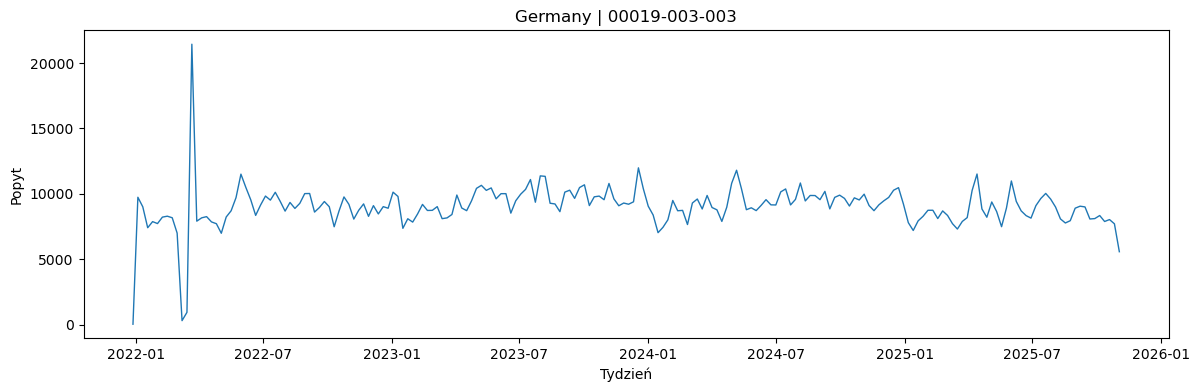

In [57]:
plt.figure(figsize=(14,4))
plt.plot(s["week_start"], s["demand"], lw=1)
plt.title(f"{COUNTRY} | {SKU}")
plt.xlabel("Tydzień")
plt.ylabel("Popyt")
plt.show()


### Rozkład wartości popytu

Analizujemy kształt rozkładu oraz obecność skośności
i wartości ekstremalnych.


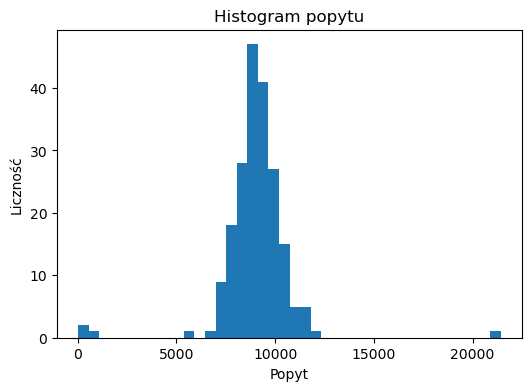

In [58]:
plt.figure(figsize=(6,4))
plt.hist(s["demand"], bins=40)
plt.title("Histogram popytu")
plt.xlabel("Popyt")
plt.ylabel("Liczność")
plt.show()



### Zmienność krocząca

Analizujemy stabilność popytu w czasie
z wykorzystaniem statystyk kroczących.


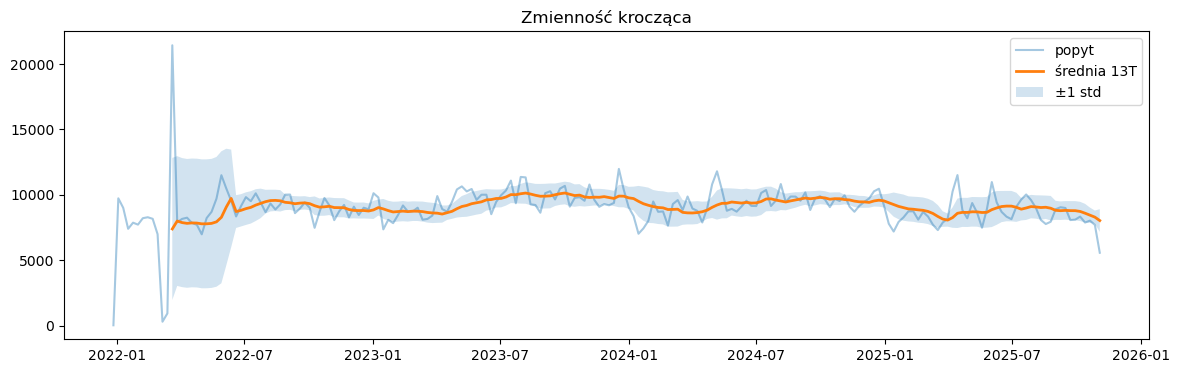

In [59]:
s["roll_mean_13"] = s["demand"].rolling(13).mean()
s["roll_std_13"] = s["demand"].rolling(13).std()

plt.figure(figsize=(14,4))
plt.plot(s["week_start"], s["demand"], alpha=0.4, label="popyt")
plt.plot(s["week_start"], s["roll_mean_13"], lw=2, label="średnia 13T")
plt.fill_between(
    s["week_start"],
    s["roll_mean_13"] - s["roll_std_13"],
    s["roll_mean_13"] + s["roll_std_13"],
    alpha=0.2,
    label="±1 std"
)
plt.legend()
plt.title("Zmienność krocząca")
plt.show()


### Profil sezonowości rocznej

Sprawdzamy powtarzalność popytu w ujęciu tygodnia roku.


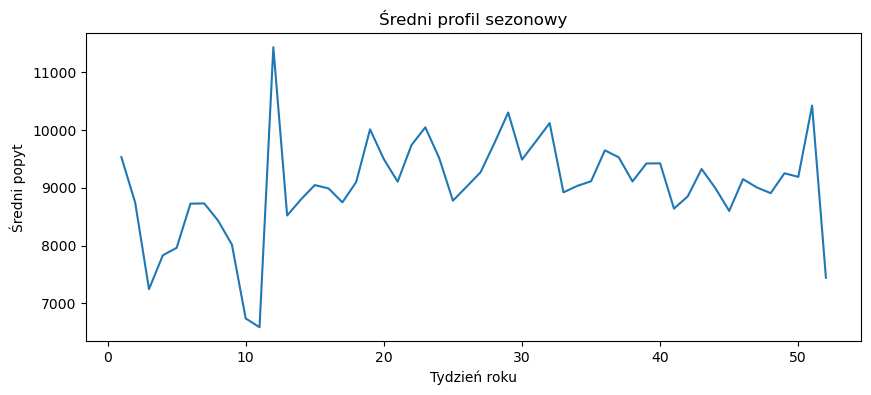

In [60]:
s["week"] = s["week_start"].dt.isocalendar().week.astype(int)

seasonal = (
    s.groupby("week")["demand"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,4))
plt.plot(seasonal["week"], seasonal["demand"])
plt.xlabel("Tydzień roku")
plt.ylabel("Średni popyt")
plt.title("Średni profil sezonowy")
plt.show()
